<center>
    
# [Компьютерное зрение](https://cogmodel.mipt.ru/wiki/index.php/%D0%9A%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%B5_%D0%B7%D1%80%D0%B5%D0%BD%D0%B8%D0%B5)

## <center> Семинар 4 - Интерполяция изображений, геометрия формирования изображения и калибровка камеры

<a target="_blank" href="https://colab.research.google.com/github/alexmelekhin/cv_course_2023/blob/main/seminars/seminar_04/Seminar_4.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

***

In [ ]:
from pathlib import Path

import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Интерполяция изображений.

![](https://github.com/alexmelekhin/cv_course_2023/blob/main/seminars/seminar_04/data/interpolation.svg?raw=1)
Задача - эффективно уменьшить/увеличить изображение.

Рассмотрим несколько методов интерполяции.

## а) Интерполяция по ближайшему пикселю

![](https://github.com/alexmelekhin/cv_course_2023/blob/main/seminars/seminar_04/data/inter_nearest.png?raw=1)

Самая простая и самая быстрая, однако она приводит к сильным артефактам.

## б) Билинейная интерполяция

![](https://github.com/alexmelekhin/cv_course_2023/blob/main/seminars/seminar_04/data/inter_linear.png?raw=1)

Лучше по качеству, но требует больше вычислений и вдобавок размывает границы объектов.

## в) Бикубическая интерполяция

![](https://github.com/alexmelekhin/cv_course_2023/blob/main/seminars/seminar_04/data/inter_cubic.png?raw=1)

Еще лучше в непрерывных областях, но на границе возникает [эффект гало](https://ru.wikipedia.org/wiki/Гало) (более темная полоса вдоль темного края границы и светлая вдоль светлого).

## Примеры

Согласно учебнику [OpenCV](https://docs.opencv.org/3.4/da/d6e/tutorial_py_geometric_transformations.html) для **сжатия изображения** — наиболее предпочтительным методом интерполяции является `cv.INTER_AREA`,
**для увеличения изображения** — наиболее предпочтительны методы интерполяции: `cv.INTER_CUBIC` (медленный) и `cv.INTER_LINEAR`.

In [ ]:
interpolation_algorithm = [ 
    ("nearest", cv2.INTER_NEAREST), 
    ("bilinear", cv2.INTER_LINEAR), 
    ("bicubic", cv2.INTER_CUBIC), 
    ("area", cv2.INTER_AREA),
    ("lanczos4", cv2.INTER_LANCZOS4)
]

def resize_by_factor(
    img: np.array,
    factor: float,
) -> None:

    height, width = img.shape[:2]
    height2, width2 = int(height*factor), int(width*factor)

    print(f'orig size: h={height}, w={width}, resised size: h={height2}, w={width2}') 

    fig, axes = plt.subplots(
        nrows=len(interpolation_algorithm),
        sharex=True,
        sharey=True,
        figsize=(3, 20)
    )

    imgs = []
    for i in range(len(interpolation_algorithm)):

        img_resized = cv2.resize(
            src=img,
            dsize=(width2, height2),
            interpolation=interpolation_algorithm[i][1],
        )

        axes[i].imshow(img_resized, cmap='Greys_r')
        axes[i].set_title(
            f"{interpolation_algorithm[i][0]}, shape = {img_resized.shape}",
        )

### Оригинальное изображение

Cloning into 'cv_course_2023'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 94 (delta 28), reused 80 (delta 15), pack-reused 0
Unpacking objects: 100% (94/94), 16.36 MiB | 8.09 MiB/s, done.


Text(0.5, 1.0, 'Original image, shape = (50, 50)')

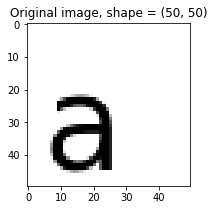

In [ ]:
IMG_PATH = "data/a_letter.png"

if not Path(IMG_PATH).exists():
    !git clone https://github.com/Ladanovasv/cv-course-2023.git
    !mv cv_course_2023/seminars/seminar_04/data .

a_letter_img = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(3, 3))
plt.imshow(a_letter_img, cmap="Greys_r")
plt.title(f"Original image, shape = {a_letter_img.shape}")

### Увеличение

orig size: h=50, w=50, resised size: h=250, w=250


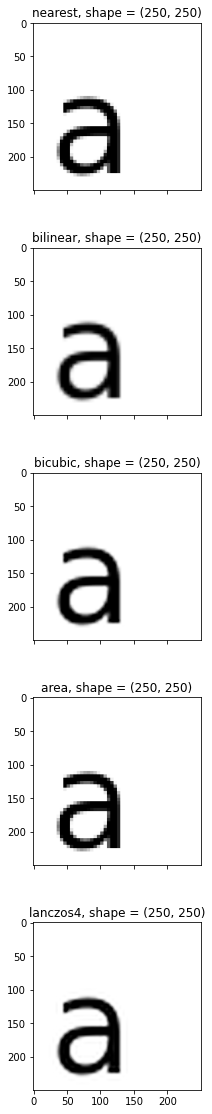

In [ ]:
resize_by_factor(
    img=a_letter_img,
    factor=5,
)

### Уменьшение

orig size: h=50, w=50, resised size: h=25, w=25


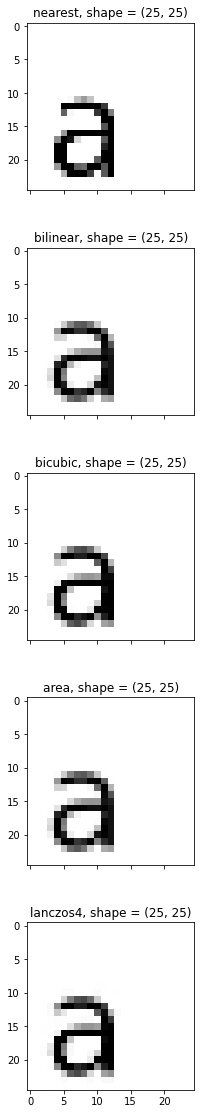

In [ ]:
resize_by_factor(
    img=a_letter_img,
    factor=0.5,
)

## Вопрос 1

Можно ли реализовать сжатие изображений на свертках? Как подбирать параметры ядра? Приведите примеры + код

**Ответ: да**
### реализация с помощью афинного преобразования


In [ ]:
def resize_image(image, t = [1, 1]):
    H, W = image.shape
    kernel = np.array([
          [t[0], 0,    0],
          [0,    t[1], 0],
          [0,    0,    1],
    ])
    # kernel = np.ones((5, 5)) / 25

    dst = np.zeros((int(H * t[1]), int(W * t[0])))
    for x in range(H):
        for y in range(W):

            p = np.dot(kernel, [x, y, 1])
            px, py = int(p[0]), int(p[1])
            if px >= 0 and px < W and py >= 0 and py < H:
                dst[py, px] = image[y, x]

    return dst
    return cv2.filter2D(image, -1, kernel)

def resize_visualization(
    img: np.array,
) -> None:

    plt.figure(figsize=(3, 3))
    plt.imshow(img, cmap="Greys_r")
    plt.title(f"Image, shape = {img.shape}")

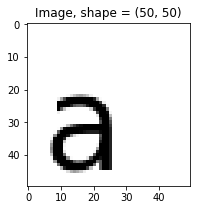

In [ ]:
a_letter_img = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
resize_visualization(resize_image(a_letter_img, t = [1, 1, 1]))

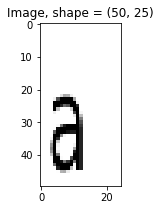

In [ ]:
a_letter_img = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
resize_visualization(resize_image(a_letter_img, t = [0.5, 1]))

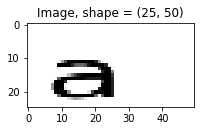

In [ ]:
a_letter_img = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
resize_visualization(resize_image(a_letter_img, t = [1, 0.5]))

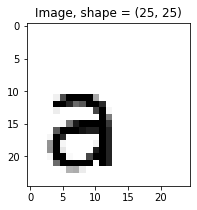

In [ ]:
a_letter_img = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
resize_visualization(resize_image(a_letter_img, t = [0.5, 0.5]))

# Трансформация изображений

Реализуется с помощью матриц 3x3

## Поворот (Rotation)

Входные параметры: угол поворота (angle)

```python
matrix = np.array([
      [np.cos(angle),  np.sin(angle), 0],
      [-np.sin(angle), np.cos(angle), 0],
      [0,              0,             1],
])
```

## Растяжение/сжатие (Scale)

Входные параметры: фактор растяжения (tx, ty)

```python
matrix = np.array([
      [t[0], 0,    0],
      [0,    t[1], 0],
      [0,    0,    1],
])
```

## Перенос (translation)

Входные параметры: фактор переноса (tx, ty)

```python
matrix = np.array([
      [1,  0, t[0]],
      [0,  1, t[1]],
      [0,  0,    1],
])
```

## Сдвиг (shearing)

Входные параметры: фактор сдвига (tx, ty)

```python
matrix_horisontal = np.array([
      [1,    t[0], 0],
      [t[1], 1,    0],
      [0,    0,    1],
])
```


## Вопрос 2

Реализуйте функцию, которая принимает изображение и матрицу преобразования, и реализует афинную трансформацию. Не забудьте про центрирование.

Идея - афинное перемещение пикселей изображения.

In [ ]:
def affine_transform(
    img: np.array,
    mat: np.array,
) -> np.array:

    # transfromed image
    transfromed_img = np.zeros_like(img)

    # image shape
    H, W = img.shape[:2]

    # center of the img
    cx, cy = (H + 1) // 2 - 1, (W + 1) // 2 - 1

    mat_centr = make_translation((cx, cy))
    mat_uncentr = make_translation((-cx, -cy))
    for x in range(H):
        for y in range(W):
            
            p = mat_centr @ mat @ mat_uncentr @ [x, y, 1]
            px, py = int(p[0]), int(p[1])
            if px >= 0 and px < W and py >= 0 and py < H:
                transfromed_img[py, px] = img[y, x]


    return transfromed_img

In [ ]:
def make_rotation(
    params,
) -> np.array:

    angle = params[0]

    mat = np.array([
      [np.cos(angle),  np.sin(angle), 0],
      [-np.sin(angle), np.cos(angle), 0],
      [0,              0,             1],
])

    return mat

def make_scaling(
    params,
) -> np.array:

    tx, ty = params[0], params[1]

    mat = np.array([
      [tx, 0,    0],
      [0,    ty, 0],
      [0,    0,    1],
])

    return mat

def make_translation(
    params,
) -> np.array:

    tx, ty = params[0], params[1]

    mat = np.array([
      [1,  0, tx],
      [0,  1, ty],
      [0,  0,    1],
])

    return mat

def make_shearing(
    params,
) -> np.array:

    tx, ty = params[0], params[1]

    mat = np.array([
      [1,    tx, 0],
      [ty, 1,    0],
      [0,    0,    1],
])

    return mat

Проверьте код на примере изображения c астронавтом

In [ ]:
import ipywidgets
from skimage import data

img = data.astronaut()

#resize image for much faster affine processing
img = cv2.resize(
    src=img,
    dsize = None,
    fx=0.3,
    fy=0.3,
    interpolation=cv2.INTER_AREA,
)

@ipywidgets.interact(
    angle=ipywidgets.FloatSlider(
        min=-3.14, max=3.14,
        step=0.01, value=0.,
    ),
)
def play_with_params(
    angle: float
) -> None:

    # an example
    mat = make_rotation(
        (angle,),
    )

    transformed_img = affine_transform(
        img=img,
        mat=mat
    )

    median = cv2.medianBlur(transformed_img, 3)
    plt.imshow(median)

interactive(children=(FloatSlider(value=0.0, description='angle', max=3.14, min=-3.14, step=0.01), Output()), …

## Вопрос 3

Запустите все 4 преобразования. Изменяйте параметры алгоритма. Имеются ли пиксели, которые никуда не перешли в результате трансформации? Что с ними можно сделать?

**Ответ:  я просто обрезала**

In [ ]:
import ipywidgets
from skimage import data

img = data.astronaut()

#resize image for much faster affine processing
img = cv2.resize(
    src=img,
    dsize = None,
    fx=0.3,
    fy=0.3,
    interpolation=cv2.INTER_AREA,
)

@ipywidgets.interact(
    trans_tx=ipywidgets.FloatSlider(
        min=-50, max=50,
        step=1, value=0.,
    ),

    trans_ty=ipywidgets.FloatSlider(
        min=-50, max=50,
        step=1, value=0.,
    ),

    scale_tx=ipywidgets.FloatSlider(
        min=0.5, max=3,
        step=0.01, value=1.,
    ),

    scale_ty=ipywidgets.FloatSlider(
        min=0.5, max=3,
        step=0.01, value=1.,
    ),

    shearing_tx=ipywidgets.FloatSlider(
        min=0, max=3,
        step=0.01, value=0.,
    ),

    shearing_ty=ipywidgets.FloatSlider(
        min=0, max=3,
        step=0.01, value=0.,
    ),

    angle=ipywidgets.FloatSlider(
        min=-3.14, max=3.14,
        step=0.01, value=0.,
    ),
)
def play_with_params(
    trans_tx: float,
    trans_ty: float,
    scale_tx: float,
    scale_ty: float,
    shearing_tx: float,
    shearing_ty: float,
    angle: float
) -> None:

    # an example
    rot_mat = make_rotation(
        (angle,),
    )

    trans_mat = make_translation(
        (trans_tx, trans_ty),
    )

    scal_mat = make_scaling(
        (scale_tx, scale_ty),
    )

    shear_mat = make_shearing(
        (shearing_tx, shearing_ty),
    )

    mat = rot_mat @ trans_mat @ scal_mat @ shear_mat

    transformed_img = affine_transform(
        img=img,
        mat=mat
    )

    plt.imshow(transformed_img)

interactive(children=(FloatSlider(value=0.0, description='trans_tx', max=50.0, min=-50.0, step=1.0), FloatSlid…

# Формирование изображения

## Внешние параметры камеры

Некоторые камеры-обскуры вносят значительные искажения в изображения. Два основных вида искажений - это радиальные искажения и тангенциальные искажения.

**Радиальные искажения** возникают из-за неидеальности линз и приводит к тому, что прямые линии кажутся изогнутыми.

**Тангенциальные искажения** возникают из-за того, что объектив для съемки изображения не выровнен идеально параллельно плоскости изображения. Таким образом, некоторые области на изображении могут выглядеть ближе, чем ожидалось. 

Виды радиального искажения:
<figure>
<img src="https://upload.wikimedia.org/wikipedia/commons/6/63/Barrel_distortion.svg" alt="drawing" width="200"/>
<figcaption>Barrel distortion (Positive k1 > 0)</figcaption>
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5b/Pincushion_distortion.svg" alt="drawing" width="200"/>
<figcaption>Pincushion distortion (Negative k1 < 0)</figcaption>
<img src="https://upload.wikimedia.org/wikipedia/commons/3/3c/Mustache_distortion.svg" alt="drawing" width="200"/>
<figcaption>Mustache distortion (Complex)</figcaption>
</figure>

Формулы:

$x_{dist} = x\frac{1+k_{1}r^{2}+k_{2}r^{4} + k_{3}r^{6}}{1+k_{4}r^{2}+k_{5}r^{4} + k_{6}r^{6}} + 2p_{1}xy + p_{2}(r^{2} + 2x^{2})$

$y_{dist} = y\frac{1+k_{1}r^{2}+k_{2}r^{4} + k_{3}r^{6}}{1+k_{4}r^{2}+k_{5}r^{4} + k_{6}r^{6}} + p_{1}(r^{2} + 2y^{2}) + 2p_{2}xy$,

где $r^{2} = x^{2} + y^{2}$

Таким образом, параметры радиальной дисторсии - ($k_{1}, \cdots, k_{6}$), тангенциальной дисторсии - ($p_{1}, p_{2}$)

В дополнение к этому нам нужны внутренние и внешние параметры камеры. Внутренние параметры специфичны для конкретной камеры. Они включают в себя такую информацию, как фокусное расстояние (fx,fy) и оптические центры (cx, cy). Фокусное расстояние и оптические центры могут быть использованы для создания матрицы камеры, которую можно использовать для устранения искажений, вызванных объективами конкретной камеры. Матрица камеры уникальна для конкретной камеры, поэтому после расчета ее можно повторно использовать на других изображениях, сделанных той же камерой.

## Вопрос 4

Запишите выражение связи точек в координатной системе камеры (X, Y, Z) c проекцией (изображением), зная параметры дисторсии и параметры камеры.

**Ответ:**


s * [x, y, 1]^T = K * [R | t] * [X, Y, Z, 1]^T

R матрица поворота world coordinates в camera coordinates
t вектор трансляции world coordinates to camera coordinates

K = [fx s cx 0 fy cy 0 0 1]


u_d = u * (1 + k_1 * r^2 + k_2 * r^4 + k_3 * r^6) 
v_d = v * (1 + k_1 * r^2 + k_2 * r^4 + k_3 * r^6)


r^2 = x^2 + y^2

## Вопрос 5

Найдите параметры вашей камеры мобильного телефона. 

Используйте шаблон шахматной доски. Можете воспользоваться ресурсом https://markhedleyjones.com/projects/calibration-checkerboard-collection  - здесь можно выбрать необходимый размер и подготовить pdf с доской. Во время печати не забудьте проверить, что масштаб не меняется (часто в параметрах печати по умолчанию установлен флаг "scale to fit page").

Воспользуйтесь [туториалом OpenCV](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html).

В ответе требуется:

1. Загрузить все сделанные фотографии (туториал рекомендует использовать не менее 10-ти изображений) в папку `./data/calibr_images`. Написанный код должен воспроизводить ваши результаты без дополнительных манипуляций.
2. Вывести найденные параметры калибровки (intrinsic матрицу и параметры дисторсии).
3. Отобразить изображения до и после устранения дисторсии.
4. Посчитать ошибку репроектирования (см. туториал opencv).

In [ ]:
import numpy as np
import cv2 as cv
import glob
# from google.colab.patches import cv2_imshow
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 25, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('./data/calibr_images/*.jpg')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (8, 6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (8,6), corners2, ret)
        # cv.imshow('img', img)
        # cv2_imshow(img)
        cv.waitKey(500)
cv.destroyAllWindows()




In [ ]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [ ]:
dist

array([[ 0.26260626, -0.96166287, -0.004544  , -0.04511496,  0.78268587]])

In [ ]:
rvecs

(array([[-0.19235773],
        [ 0.05628831],
        [-0.26620793]]), array([[-0.33983817],
        [-0.32123603],
        [ 0.09499101]]), array([[-0.1765552 ],
        [ 0.09968297],
        [-0.07908742]]), array([[-0.54672834],
        [ 0.09493154],
        [ 0.01735023]]), array([[-0.21790426],
        [ 0.06225122],
        [ 0.321481  ]]), array([[-0.00432294],
        [-0.03497712],
        [ 0.55844355]]), array([[0.09355499],
        [0.15580337],
        [0.99122122]]), array([[-0.21081069],
        [ 0.11761647],
        [-0.41098039]]), array([[-0.18796167],
        [ 0.03497319],
        [-0.04867145]]), array([[-0.07858153],
        [ 0.17088842],
        [-0.92135759]]))

In [ ]:
tvecs

(array([[-2.29690812],
        [-1.25640884],
        [16.84275391]]), array([[-1.44493816],
        [-2.92846085],
        [14.80045258]]), array([[-0.86917737],
        [-2.67466989],
        [19.05275859]]), array([[-1.60377991],
        [-3.37467641],
        [17.51586683]]), array([[-0.8098402 ],
        [-3.32718208],
        [17.25062954]]), array([[ 0.31146728],
        [-3.76219683],
        [18.83953033]]), array([[-4.98911316],
        [ 3.716578  ],
        [17.84123523]]), array([[-1.53158415],
        [-0.92476961],
        [19.1315371 ]]), array([[-2.83197291],
        [-1.71747982],
        [15.84254275]]), array([[-9.29093106],
        [ 8.22831325],
        [19.23151831]]))

In [ ]:
ret

2.25967077644805

In [ ]:
mtx

array([[2.23012736e+03, 0.00000000e+00, 1.42380862e+03],
       [0.00000000e+00, 2.20714893e+03, 7.29506521e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [ ]:
img = cv.imread("./data/calibr_images/IMG20230222164231.jpg")
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

In [ ]:
# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

In [ ]:
dst

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [ ]:
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv.imwrite('calibresult.png', dst)

True

In [ ]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.27827810025675853
